# Semantic Scholar データの基本操作

In [29]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
year_pattern = r'([1-2][0-9]{3})'

In [30]:
DATAPATH = "../../data/"
# with open(DATAPATH + "arxiv-metadata-oai-snapshot.json", 'r') as f:
#     authors = json.load(f)

In [3]:
"""
Json files in the dataset are huge. Sadly, python has certain memory problems when loading huge json files.
As a result, I read this file using `yield` and get necessary information from in in the loop.
"""

def get_metadata():
    with open(DATAPATH + 'arxiv-metadata-oai-snapshot.json', 'r') as f:
        for line in f:
            yield line

In [4]:
metadata = get_metadata()
for paper in metadata:
    for k, v in json.loads(paper).items():
        print(f'{k}: {v}')
    break

id: 0704.0001
submitter: Pavel Nadolsky
authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments: 37 pages, 15 figures; published version
journal-ref: Phys.Rev.D76:013009,2007
doi: 10.1103/PhysRevD.76.013009
report-no: ANL-HEP-PR-07-12
categories: hep-ph
license: None
abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests w

In [5]:
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'}

In [6]:
%%time

dates = []
titles = []
abstracts = []
categories = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(category_map.keys())).flatten()

# Uncomment & edit below line to use specific paper categories to be used during training and prediction
# paper_categories = ["astro-ph", # Astrophysics
#                     "cs.CV", # Computer Vision and Pattern Recognition
#                     'q-fin.EC'] # Economics

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    category = list(category.split(" "))
    try:
        d = paper_dict.get('versions')[0].get('created')
        t = paper_dict.get('title')
        a = paper_dict.get('abstract')
        for c in category:
            dates.append(d)
            titles.append(t)
            abstracts.append(a)
            categories.append(c)
    except Exception as e:
        print(e)
        print(paper_dict)
        break

len(dates), len(titles), len(abstracts), len(categories)

0it [00:00, ?it/s]

CPU times: user 21.8 s, sys: 4.17 s, total: 25.9 s
Wall time: 23.9 s


(3423191, 3423191, 3423191, 3423191)

In [7]:
df = pd.DataFrame(data=dates, columns=["date"])
df["title"] = titles
df["abstract"] = abstracts
df["category"] = categories
df.head()

date  \
0   Mon, 2 Apr 2007 19:18:42 GMT   
1  Sat, 31 Mar 2007 02:26:18 GMT   
2  Sat, 31 Mar 2007 02:26:18 GMT   
3   Sun, 1 Apr 2007 20:46:54 GMT   
4  Sat, 31 Mar 2007 03:16:14 GMT   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2           Sparsity-certifying Graph Decompositions   
3  The evolution of the Earth-Moon system based o...   
4  A determinant of Stirling cycle numbers counts...   

                                            abstract        category  
0    A fully differential calculation in perturba...          hep-ph  
1    We describe a new algorithm, the $(k,\ell)$-...         math.CO  
2    We describe a new algorithm, the $(k,\ell)$-...           cs.CG  
3    The evolution of Earth-Moon system is descri...  physics.gen-ph  
4    We show that a determinant of Stirling cycle...         math.CO

In [8]:
df["date"] = df["date"].map(lambda x: dt.datetime.strptime( x, '%a, %d %b %Y %H:%M:%S GMT'))
df["dt"] = df["date"].map(lambda x: dt.date( x.year, x.month, 1))
df.head()

date                                              title  \
0 2007-04-02 19:18:42  Calculation of prompt diphoton production cros...   
1 2007-03-31 02:26:18           Sparsity-certifying Graph Decompositions   
2 2007-03-31 02:26:18           Sparsity-certifying Graph Decompositions   
3 2007-04-01 20:46:54  The evolution of the Earth-Moon system based o...   
4 2007-03-31 03:16:14  A determinant of Stirling cycle numbers counts...   

                                            abstract        category  \
0    A fully differential calculation in perturba...          hep-ph   
1    We describe a new algorithm, the $(k,\ell)$-...         math.CO   
2    We describe a new algorithm, the $(k,\ell)$-...           cs.CG   
3    The evolution of Earth-Moon system is descri...  physics.gen-ph   
4    We show that a determinant of Stirling cycle...         math.CO   

           dt  
0  2007-04-01  
1  2007-03-01  
2  2007-03-01  
3  2007-04-01  
4  2007-03-01

In [10]:
df_s = df.groupby(["category", "dt"], as_index=False).count()
df_s

category          dt  date  title  abstract
0      acc-phys  1994-11-01     4      4         4
1      acc-phys  1995-02-01     2      2         2
2      acc-phys  1995-03-01     4      4         4
3      acc-phys  1995-04-01     3      3         3
4      acc-phys  1995-05-01     2      2         2
...         ...         ...   ...    ...       ...
42647  supr-con  1996-05-01     7      7         7
42648  supr-con  1996-06-01     6      6         6
42649  supr-con  1996-07-01    13     13        13
42650  supr-con  1996-08-01    14     14        14
42651  supr-con  1996-09-01     5      5         5

[42652 rows x 5 columns]

In [13]:
df_t = df.groupby(["category"], as_index=False).count()
df_t.sort_values("title", inplace=True)
x = df_t.tail(10)["category"].values.tolist()

In [16]:
df_s = df_s[df_s["category"].isin(x)]
df_s

category          dt  date  title  abstract
182    astro-ph  1992-04-01     6      6         6
183    astro-ph  1992-05-01     7      7         7
184    astro-ph  1992-06-01    11     11        11
185    astro-ph  1992-07-01    11     11        11
186    astro-ph  1992-08-01    18     18        18
...         ...         ...   ...    ...       ...
41377  quant-ph  2021-12-01  1017   1017      1017
41378  quant-ph  2022-01-01   773    773       773
41379  quant-ph  2022-02-01   794    794       794
41380  quant-ph  2022-03-01   968    968       968
41381  quant-ph  2022-04-01   564    564       564

[3145 rows x 5 columns]

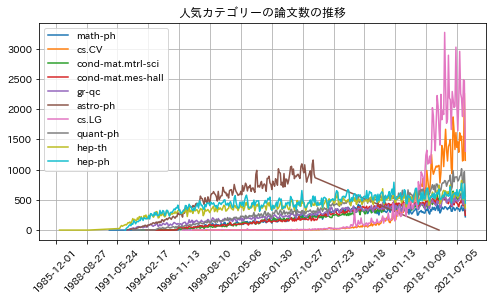

In [31]:
# 描画
fig, ax = plt.subplots(figsize=(8, 4))
for i in x:
    target_df = df_s[df_s["category"] == i]
    ax.plot(target_df["dt"], target_df["title"], label=i)
# 軸目盛の設定
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1000, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

## 補助目盛りを使いたい場合や時刻まで表示したい場合は以下を調整して使用
# ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1), tz=None))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))

# 軸目盛ラベルの回転
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10);

ax.set_title("人気カテゴリーの論文数の推移")
ax.legend()
ax.grid()
fig.set_facecolor("w")
fig.show()